In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import linear_model
import statsmodels.api as sm
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
import xgboost as xg

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
data = pd.read_csv("harvest_data_plus_environmental_data.csv")

## EDA:

Text(0.5, 1.0, 'Average age of white-tailed deer by training site')

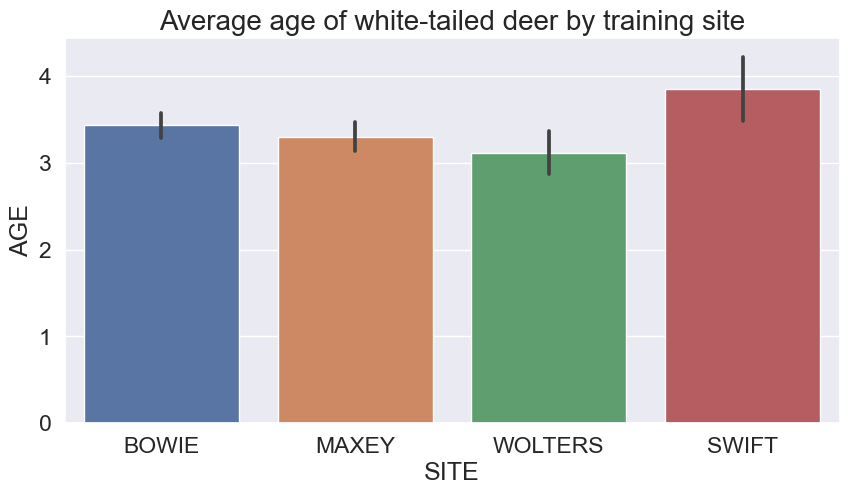

In [3]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average age of white-tailed deer by training site', fontsize=20)

Text(0.5, 1.0, 'Number of individuals harvested by year')

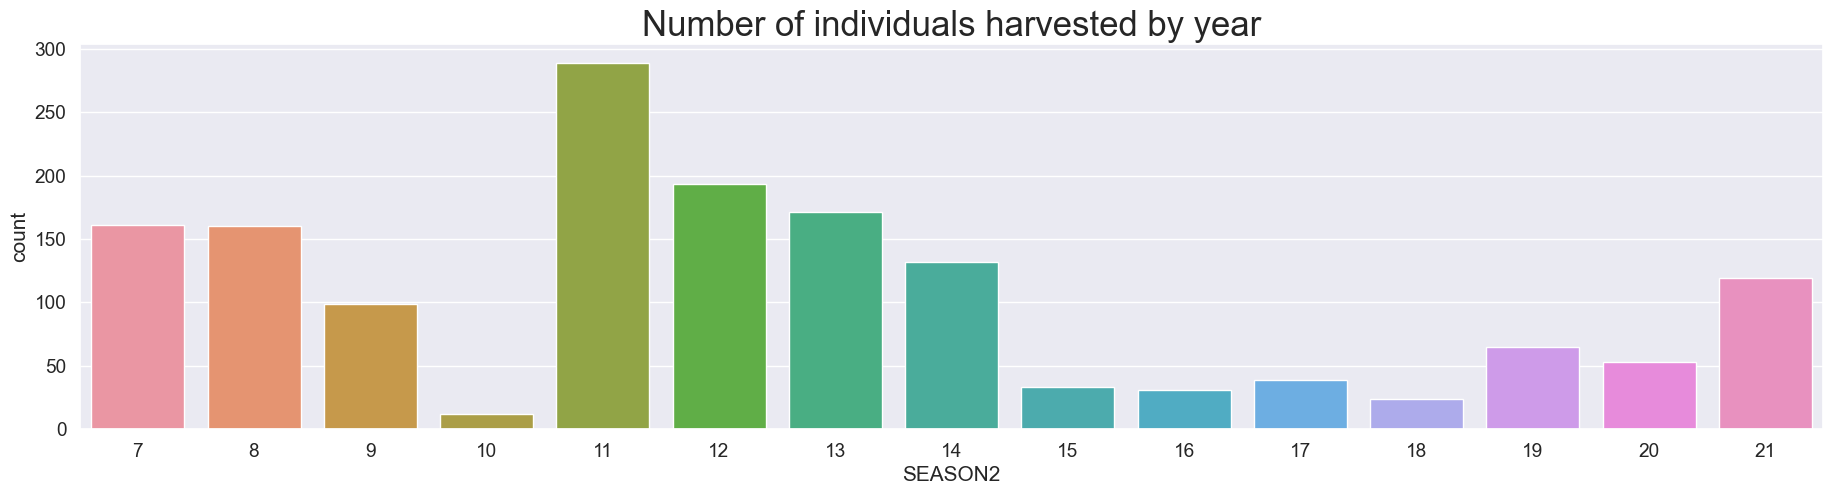

In [4]:
sns.set(rc={"figure.figsize":(22.5, 5)}, font_scale = 1.25) 
sns.countplot(x = 'SEASON2', data = data)
plt.title('Number of individuals harvested by year', fontsize=25) 
## the x-axis values correspond to year (e.g., '7' = 2007, '10' = 2010, and so on.)

Text(0.5, 1.0, 'Scatterplot with trend line of body mass (bm.kg) by age')

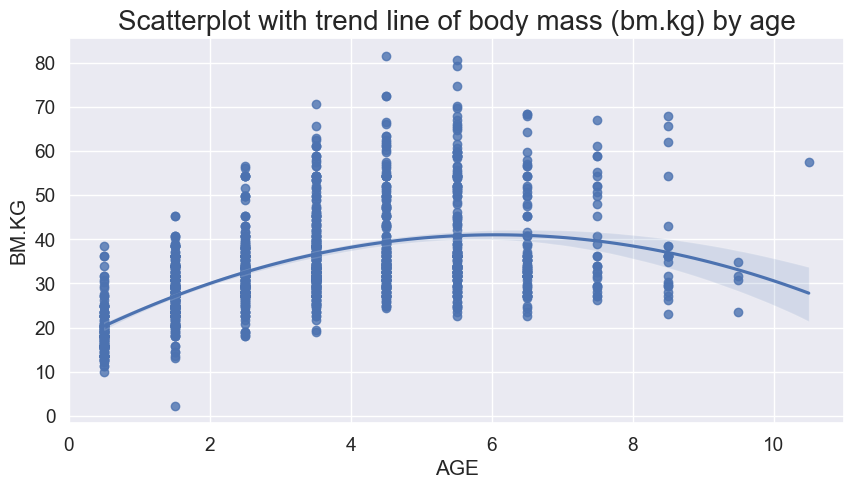

In [5]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.25) 
sns.regplot(x = 'AGE', y = 'BM.KG', data = data, order=2)
plt.title('Scatterplot with trend line of body mass (bm.kg) by age', fontsize=20)

Notice the positive, curvilinear relationship between age and body mass.  However, as individuals reach about 6 years, the rate of decrease in body mass accelerates 

In [6]:
data.drop(['PREFIX-ID','DATE','ID','DATE+#','a,b,etc.','DATE TAKEN','SEASON','SEASONCAT','LIVE.BM.KG',
           'LIVE WEIGHT','BM.LB','POINTS.L','POINTS.R','SPREAD.IN','SPREAD.MM','BASAL.CIR.L.IN',
           'BASAL.CIR.L.MM','BASAL.CIR.R.IN','BASAL.CIR.R.MM ','BEAM.L.IN','BASAL.T.MM','BEAM.L.MM',
           'BEAM.R.IN','BEAM.R.MM','LACTATION','NOTES','BEAM.T.MM'],axis=1, inplace=True)

In [7]:
data['SITE'].replace(['BOWIE', 'SWIFT','MAXEY','WOLTERS'],[0, 1, 2, 3], inplace=True)
data['SEX'].replace(['M','F'],[0, 1], inplace=True)

In [8]:
data.dropna(subset=['BM.KG','AGE'],inplace=True)

In [9]:
data

,SEASON2,SEX,SITE,AGE,BM.KG,rain_lag_0,rain_lag_1,rain_lag_2,rain_lag_3,rain_lag_4,rain_lag_5
0,7,1,0,5.5,32.653061,42.21,24.70,30.53,39.47,30.05,24.985
1,7,1,0,2.5,27.210884,42.21,24.70,30.53,39.47,30.05,24.985
2,7,1,0,3.5,27.210884,42.21,24.70,30.53,39.47,30.05,24.985
3,7,1,0,6.5,27.210884,42.21,24.70,30.53,39.47,30.05,24.985
4,7,1,0,7.5,29.024943,42.21,24.70,30.53,39.47,30.05,24.985
...,...,...,...,...,...,...,...,...,...,...,...
1576,21,1,3,4.5,32.653061,41.53,34.75,36.36,38.38,28.12,40.200
1577,21,0,3,7.5,52.154195,41.53,34.75,36.36,38.38,28.12,40.200
1578,21,1,3,1.5,20.408163,41.53,34.75,36.36,38.38,28.12,40.200
1579,21,1,3,3.5,29.024943,41.53,34.75,36.36,38.38,28.12,40.200


In [10]:
print("Total NaN in dataframe :" , data.isna().sum().sum())
print("Total NaN in each column of the dataframe")
na = []
for index, col in enumerate(data):
    na.append((index, data[col].isna().sum())) 
na_sorted = na.copy()
na_sorted.sort(key = lambda x: x[1], reverse = True) 

for i in range(len(data.columns)):
    print(data.columns[na_sorted[i][0]],":", na_sorted[i][1], "NaN")

Total NaN in dataframe : 0
Total NaN in each column of the dataframe
SEASON2 : 0 NaN
SEX : 0 NaN
SITE : 0 NaN
AGE : 0 NaN
BM.KG : 0 NaN
rain_lag_0 : 0 NaN
rain_lag_1 : 0 NaN
rain_lag_2 : 0 NaN
rain_lag_3 : 0 NaN
rain_lag_4 : 0 NaN
rain_lag_5 : 0 NaN


Text(0.5, 1.0, 'Average age by training site')

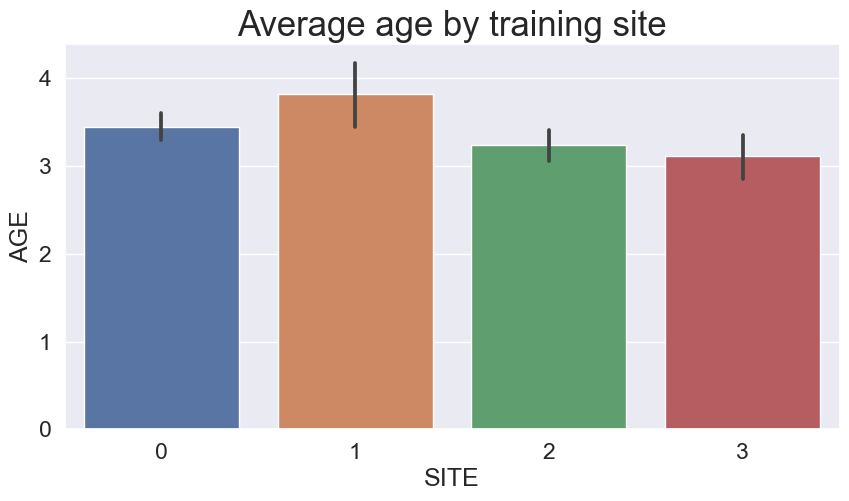

In [11]:
sns.set(rc={"figure.figsize":(10, 5)}, font_scale = 1.5) 
sns.barplot(x = 'SITE', y='AGE', data = data, ci=95)
plt.title('Average age by training site', fontsize=25)

In [12]:
data.corr() # looking at correlations between rain_lags.  Dropping all that correlate highly with other rain_lags

,SEASON2,SEX,SITE,AGE,BM.KG,rain_lag_0,rain_lag_1,rain_lag_2,rain_lag_3,rain_lag_4,rain_lag_5
SEASON2,1.000000,-0.151641,0.143443,0.063519,0.289050,-0.049558,-0.080371,-0.011671,0.063936,0.061069,0.022385
SEX,-0.151641,1.000000,0.079727,-0.038423,-0.537999,0.053042,0.035436,0.049846,-0.036867,-0.026785,0.058978
SITE,0.143443,0.079727,1.000000,-0.066949,-0.041102,0.413173,0.400234,0.422409,0.344719,0.308553,0.389281
AGE,0.063519,-0.038423,-0.066949,1.000000,0.516062,-0.043754,-0.017879,-0.001917,-0.011239,0.006680,-0.045170
BM.KG,0.289050,-0.537999,-0.041102,0.516062,1.000000,-0.021724,-0.042506,0.007489,0.104425,0.121947,-0.037215
rain_lag_0,-0.049558,0.053042,0.413173,-0.043754,-0.021724,1.000000,0.863983,0.908975,0.819211,0.681594,0.711424
rain_lag_1,-0.080371,0.035436,0.400234,-0.017879,-0.042506,0.863983,1.000000,0.843075,0.686674,0.683089,0.773182
rain_lag_2,-0.011671,0.049846,0.422409,-0.001917,0.007489,0.908975,0.843075,1.000000,0.768484,0.648440,0.710522
rain_lag_3,0.063936,-0.036867,0.344719,-0.011239,0.104425,0.819211,0.686674,0.768484,1.000000,0.751271,0.410308
rain_lag_4,0.061069,-0.026785,0.308553,0.006680,0.121947,0.681594,0.683089,0.648440,0.751271,1.000000,0.388001


In [13]:
X = data[['AGE', 'SEX', 'SEASON2', 'rain_lag_4', 'rain_lag_3']] # kept rain lag 3 and 4 because they are the only lags that don't correlate highly with other lags

y = data['BM.KG']

In [14]:
## Going to fit a linear regression model initially 

In [15]:
X2 = sm.add_constant(X)
est = sm.OLS(y, X2)
est2 = est.fit()
print(est2.summary()) ## not a bad r-squared.  

                            OLS Regression Results                            
Dep. Variable:                  BM.KG   R-squared:                       0.577
Model:                            OLS   Adj. R-squared:                  0.576
Method:                 Least Squares   F-statistic:                     390.7
Date:                Mon, 05 Dec 2022   Prob (F-statistic):          2.01e-264
Time:                        19:18:57   Log-Likelihood:                -4905.5
No. Observations:                1437   AIC:                             9823.
Df Residuals:                    1431   BIC:                             9855.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         24.0407      0.953     25.229      0.0

In [16]:
pred = est2.predict(X2)
print(pred)

0       32.740887
1       24.381127
2       27.167713
3       35.527473
4       38.314060
          ...    
1576    36.837205
1577    57.629966
1578    28.477445
1579    34.050619
1580    43.697032
Length: 1437, dtype: float64


In [17]:
mae = mean_absolute_error(data['BM.KG'], pred)
print("mean absolute error for the MLR {}".format(mae))

mean absolute error for the MLR 5.544773964498387


In [18]:
## going to fit a few machine learning models.  Going to see if predictors' feature importances vary among fitted and tuned models

In [19]:
rf = RandomForestRegressor(random_state = 1)
gb = GradientBoostingRegressor(random_state = 1)
xgbr = xg.XGBRegressor(random_state = 1)

In [20]:
## KFold cross validation to evaluate model performance

In [21]:
scores_rf = cross_val_score(rf,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_rf = (-scores_rf)
print("MAE values: ", mae_rf)
print("MAE average: ", np.mean(mae_rf))

MAE values:  [4.53817124 4.28744244 4.81273903 3.52983602 5.03379841 5.37865345
 4.32193668 4.63371477 6.0946824  5.40725375]
MAE average:  4.803822817910395


In [22]:
scores_gb = cross_val_score(gb,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_gb = (-scores_gb)
print("MAE values: ", mae_gb)
print("MAE average: ", np.mean(mae_gb))

MAE values:  [4.28832023 4.0455797  4.68727415 3.13165377 4.95765929 5.11008799
 4.30598659 5.57662852 5.65647397 5.21348161]
MAE average:  4.697314582195689


In [23]:
scores_xgbr = cross_val_score(xgbr,X,y,scoring="neg_mean_absolute_error",cv=10)
mae_xgbr = (-scores_xgbr)
print("MAE values: ", mae_xgbr)
print("MAE average: ", np.mean(mae_xgbr))

C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future

MAE values:  [4.67002747 4.32523545 4.89648596 3.7394839  5.47065749 5.78213184
 4.79141628 5.81266092 6.16549836 5.48361689]
MAE average:  5.113721455629825


In [24]:
params = [{'n_estimators':np.arange(5,100,5),
           'max_features':np.arange(0.1,1.0,0.05)}]

In [25]:
gs_rf = GridSearchCV(estimator = rf, 
                           param_grid = params,
                           cv=5, 
                           scoring="r2",
                           verbose=1,
                           n_jobs=-1)

In [26]:
gs_gb = GridSearchCV(estimator = gb, 
                           param_grid = params,
                           cv=5, 
                           scoring="r2",
                           verbose=1,
                           n_jobs=-1)

In [27]:
gs_xgbr = GridSearchCV(estimator = xgbr, 
                           param_grid = params,
                           cv=5, 
                           scoring="r2",
                           verbose=1,
                           n_jobs=-1)

In [28]:
gs_rf.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=1), n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='r2', verbose=1)

In [29]:
gs_gb.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits


GridSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=1),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='r2', verbose=1)

In [30]:
gs_xgbr.fit(X,y)

Fitting 5 folds for each of 342 candidates, totalling 1710 fits
[19:21:35] WARNING: C:\Windows\Temp\abs_557yfx631l\croots\recipe\xgboost-split_1659548953302\work\src\learner.cc:576: 
Parameters: { "max_features" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




C:\Users\wpson\anaconda3\lib\site-packages\xgboost\data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    enable_categorical=False, gamma=None,
                                    gpu_id=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_delta_step=None,
                                    max_depth=None, min_child_weight=None,
                                    missing=nan, monotone_constraints=None,
                                    n...
                                    random_state=1, reg_alpha=None,
                                    reg_lambda=None, scale_pos_weight=None,
                                    subsample=None, tree_method=None,
                                    validate_parameters=None, verbosity=None),
             n_jobs=-1,
             param_grid=[{'max_features': array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95]),
                          'n_estimators': array([ 5, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60, 65, 70, 75, 80, 85,
       90, 95])}],
             scoring='r2', verbose=1)

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'AGE'),
  Text(1, 0, 'SEX'),
  Text(2, 0, 'rain_lag_4'),
  Text(3, 0, 'SEASON2'),
  Text(4, 0, 'rain_lag_3')])

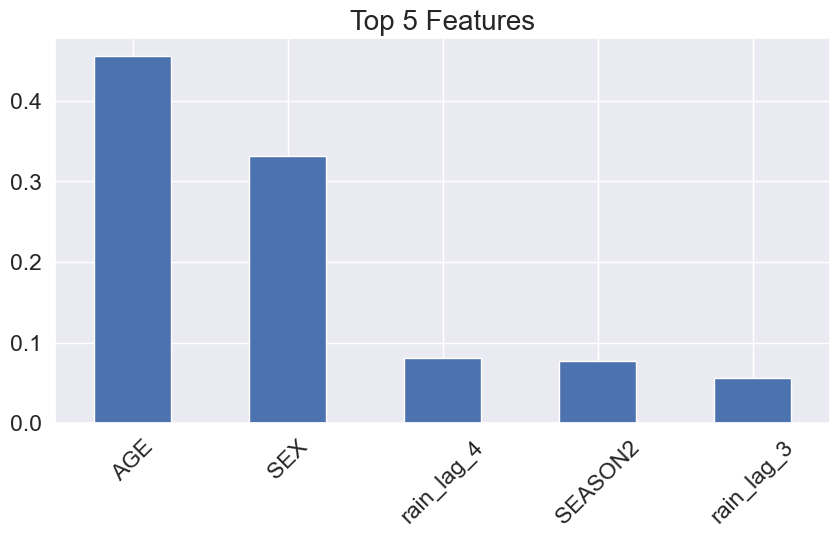

In [31]:
feat_importances = pd.Series(gs_rf.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'AGE'),
  Text(1, 0, 'SEX'),
  Text(2, 0, 'rain_lag_4'),
  Text(3, 0, 'SEASON2'),
  Text(4, 0, 'rain_lag_3')])

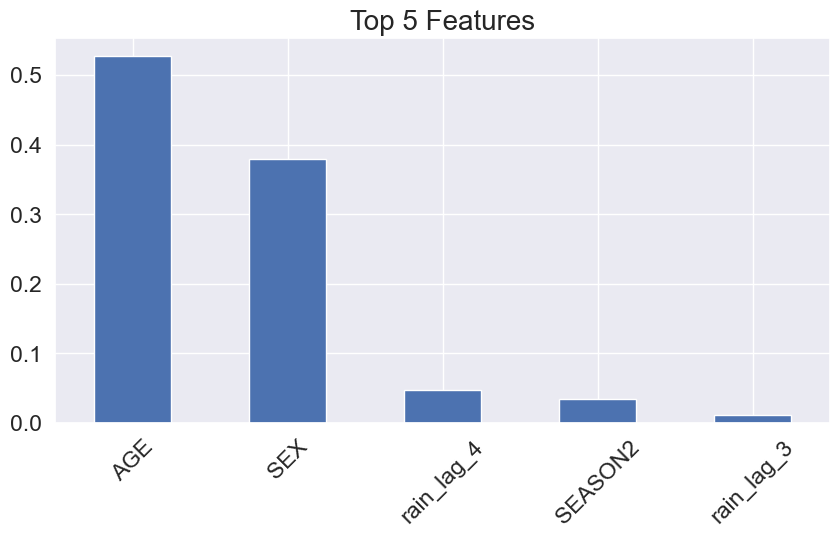

In [32]:
feat_importances = pd.Series(gs_gb.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 

(array([0, 1, 2, 3, 4]),
 [Text(0, 0, 'SEX'),
  Text(1, 0, 'AGE'),
  Text(2, 0, 'rain_lag_4'),
  Text(3, 0, 'rain_lag_3'),
  Text(4, 0, 'SEASON2')])

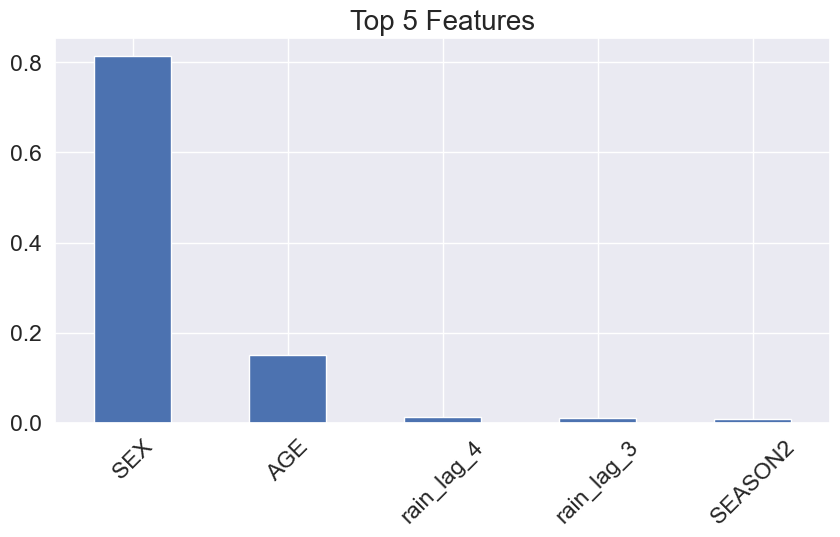

In [33]:
feat_importances = pd.Series(gs_xgbr.best_estimator_.feature_importances_, index=X.columns)
feat_importances.nlargest(5).plot(kind='bar')
titlefont = 20
plt.title("Top 5 Features", fontdict={'fontsize':titlefont})
plt.xticks(rotation = 45) 